# Install all needed package 

In [24]:
# install.packages('lubridate')
# install.packages('dplyr')
# install.packages('tidyr')
# install.packages('magrittr')
# install.packages('RcppRoll')
# install.packages('wrapr')
# install.packages('sqldf')
# install.packages('repmis')
# install.packages('remotes')
# remotes::install_github("Sibada/scPDSI")
# install.packages("SPEI")
# install.packages("humidity")
# install.packages("cowplot")
Libs=c('lubridate','dplyr','purrr','tidyr','magrittr','RcppRoll','wrapr','knitr','data.table','magrittr','ggplot2','cowplot','humidity','SPEI')
lapply(Libs,library, character.only = TRUE)
setwd('./')

# Set theme for plotting

In [3]:
Plot_theme=theme_bw()+
  theme(axis.text=element_text(size=12, 
                               color="grey12"),
        axis.title=element_text(size=14),
        plot.title=element_text(size=18,
                                face="bold"),
        legend.position="bottom",
        legend.title=element_text(size=14),
        legend.text=element_text(size=14, 
                                 color="grey12"),
        strip.text.y = element_text(size = 12),
        strip.text.x = element_text(size = 12),
        axis.text.x = element_text(angle = 45, hjust = 1))

theme_Result= theme(panel.background = element_rect(fill = "white"),
                    panel.grid.major = element_line(colour = "light grey"),
                    panel.border = element_rect(colour="black",fill=NA),
                    line = element_line(colour = "black", size = 0.5, linetype = 1),
                    axis.text.x = element_text(size=10,colour='black'),
                    axis.text.y = element_text(size=16,colour='black'),
                    axis.title.y = element_text(size = 18),
                    axis.title.x = element_text(size = 18),
                    plot.title = element_text(size = 20),
                    legend.text=element_text(size=18),
                    legend.title=element_text(size=18,face='plain'),
                    legend.position='bottom')

# All the complementary functions
1. Function for regulating time interval
2. Function for padding location
3. Function for separating dry and wet events
4. Function for getting pressure change events
5. Data clean

#### 1.Function for regulating time interval

In [4]:
source('https://raw.githubusercontent.com/ZyuAFD/SWRE_General_R_Functions/master/src/Regulate%205%20min.R')

#### 2. Function for padding location

In [5]:
pad_loc=function(x,df)
{
  loc = unique(df$Location)
  x %>% 
    #pad(interval="hour") %>% 
    replace_na(list(Location=loc)) %>% 
    return
}

#### 3. Function for separating dry and wet events

In [6]:
Precip_Evt_Sep= function(dt,T_intv,IntE_P)
  #dt:       data of time and rain
  #T_intv:   Time interval of the time series (mins)
  #IntE_P:   Inter event period 
  #           (time step based your time interval
  #            For example: in a 5 min time interval series
  #            a 4 hour inter event period is corresponding to
  #            48 for IntE_P)
  # output: 
  #   Odd Evt_lab: Rain event
  #   Even Evt_lab: Dry event
{
  
  dt %>% 
    replace_na(list(Rain=0)) %>% 
    mutate(Cum_Precip_4hr_L=roll_sum(Rain,IntE_P+1,align='left',fill=0),
           Cum_Precip_4hr_R=roll_sum(Rain,IntE_P+1,align='right',fill=0)) %>% 
    mutate(StR=ifelse(lag(Cum_Precip_4hr_R)==0 & Rain>0,1,0),
           StD=ifelse(lag(Cum_Precip_4hr_L)>0 & Cum_Precip_4hr_L==0 & Rain==0,1,0)) %>% 
    replace_na(list(StR=0,StD=0)) %>% 
    mutate(Evt_lab=StR+StD) %>% 
    mutate(Evt_lab=cumsum(Evt_lab)) %>% 
    select(-Cum_Precip_4hr_L,-Cum_Precip_4hr_R) %>% 
    return
}

#### 4.  Function for getting pressure change events

In [7]:
Get_Press_Evt_lab=function(Dt) 
{
  Dt %>% 
    arrange(Time)%>%
    mutate(Mon=month(Time)) %>% 
    # Roll average over 24 hours
    mutate(Press_Evt_lab=ifelse(Pressure_chng.av*lag(Pressure_chng.av)<=0 & lag(Pressure_chng.av)!=0,1,0)) %>% 
    mutate(Press_Evt_lab=ifelse(is.na(Press_Evt_lab),0,Press_Evt_lab)) %>% 
    mutate(Press_Evt_lab=cumsum(Press_Evt_lab)) %>% 
    mutate(kelvin_temp = convert_fahr_to_kelvin(Temp_C)) %>% 
    mutate(Es = SVP(kelvin_temp)) %>% 
    mutate(e = WVP2(RH, Es)) %>% 
    mutate(AH = AH(e, kelvin_temp)) %>% 
    mutate(AH_new = ifelse(Rain > 0 & RH > 85, AH, NA)) %>% 
    mutate(R_T = ifelse(Rain > 0 & RH > 85, Temp_C, NA)) %>% 
    return
}



Get_Press_Evt=function(Dt)
{
  Dt %>% 
    mutate(Mon=month(Time),
           Yr=year(Time)) %>% 
    group_by(Yr,Mon) %>% 
    summarise(MonT=mean(Temp_C,na.rm=T))->Dt_MonT
  
  Dt %>% 
    filter(Press_Evt_lab>0,
           Press_Evt_lab<max(Press_Evt_lab)) %>% 
    group_by(Press_Evt_lab,Location) %>% 
    summarise(St=min(Time),
              End=max(Time),
              Dur=as.numeric(max(Time)-min(Time),units='hours')+1,
              Sum_Press_Delta=sum(Pressure_chng.av),
              Press_NA=sum(is.na(Pressure_hPa)),
              Temp_NA=sum(is.na(Temp_C)),
              Sum_Precip=sum(Rain,na.rm=T),
              Rain_temp = mean(R_T, na.rm=T),
              Avg_AH = mean(AH_new, na.rm=T),
              St_Rain=sum(StR),
              St_Dry=sum(StD)) %>% 
    filter(Dur<1000) %>% #take events with more than 10000 hours as gap
    mutate(Yr=year(St),
           Mon=month(St)) %>% 
    left_join(.,Dt_MonT,by=c('Yr'='Yr','Mon'='Mon')) %>% 
    ungroup %>% 
    arrange(St) %>% 
    mutate(Dur_lag1=lag(Dur),
           Press_Delta_lag1=lag(Sum_Press_Delta)) %>% 
    
    return
}

#### 5. data clean

In [8]:
data_preprosessing = function(DtF)
{
  DtF %>%
    arrange(Time) %>%
    mutate(St=lag(Time)) %>% 
    mutate(TimeLag_min=as.numeric(Time-St,units='mins')) %>% 
    mutate(Years=year(Time))%>% 
    rename(End=Time) %>% 
    relocate(St,.before = End)->DtF_TimeLag 
  
  # DtF_TimeLag %>%
  # group_by(TimeLag_min) %>% 
  # tally %>%
  # rename(Num_lag=n) %>%
  # kable
  
  
  
  
  # find the time where the gap is larger than 4 hours
  DtF_TimeLag %>%
    group_by(TimeLag_min) %>%
    filter(TimeLag_min >= 240) -> df_gap
  
  # find the time where the gap number is larger than 100, get all gaps
  DtF_TimeLag %>%
    group_by(TimeLag_min) %>%
    filter(TimeLag_min > 60 & TimeLag_min < 240) %>%
    count(TimeLag_min)%>% 
    filter(n>100) %>%
    select(-n) %>% 
    left_join(DtF_TimeLag) %>% 
    relocate(TimeLag_min,.before = Years) %>% 
    bind_rows(df_gap) %>% 
    arrange(St)-> DtF_gap
  
  
  # regulate time
  interval = 60
  
  
  DtF %>% 
    Regular_Time(.,interval) %>% 
    do(pad_loc(.,DtF)) -> DtF_clean
  # 
  # DtF_clean %>% 
  #   filter(is.na(Location)== T)
  
  # remove 0 time interval
  DtF_clean %>% 
    group_by(Time,Location) %>%
    summarise(Rain=mean(ifelse(Rain>0 & Rain<999.9,Rain,NA),na.rm=T),Pressure_hPa=mean(Pressure_hPa,na.rm=TRUE),Temp_C=mean(Temp_C,na.rm=TRUE),
              DewPt_C=mean(DewPt_C,na.rm=TRUE),RH=mean(RH,na.rm=TRUE),Wind_SP_m_s=mean(Wind_SP_m_s,na.rm=TRUE)) %>% 
    ungroup() -> DtF_rm_zero
  
  # DtF_rm_zero %>%
  #   arrange(Time) %>%
  #   mutate(TimeLag_min=as.numeric(Time-lag(Time),units='mins')) %>%
  #   group_by(TimeLag_min) %>%
  #   tally %>%
  #   rename(Num_lag=n) %>%
  #   kable
  
  DtF_rm_zero %>% 
    filter(is.na(Location)== T)
  
  # fill gap, do moving average calculate lag pressure lag of 24-hour
  DtF_rm_zero %>% 
    # spline the pressure
    mutate(Pressure_hPa.spl=spline(x=Time,y=Pressure_hPa,xout=Time)$y) %>%
    # moving average
    mutate(Pressure_hPa.av=roll_mean(Pressure_hPa.spl,n=24,align='center',fill=NA)) %>% 
    #Change of Pressure in 24 hours
    mutate(Pressure_chng.av=Pressure_hPa.av-lag(Pressure_hPa.av,24)) %>%  
    ungroup->Climate_Dt
  
  IntE_P = 4
  # rain events
  Climate_Dt %>% 
    Precip_Evt_Sep(.,interval,IntE_P) -> DtF_sep
  
  DtF_sep %>% 
    select(Time,Rain,Evt_lab) %>% 
    filter(Evt_lab>0, Evt_lab<max(Evt_lab)) %>% 
    group_by(Evt_lab) %>% 
    summarise(Start=min(Time),
              End=max(Time),
              TotalRain=round(sum(Rain),3),
              Max_Intensity=max(Rain), # Maximium rain intensity based on time interval
              Dur_hr=as.numeric(max(Time+minutes(60))-min(Time),units='hours')) %>% 
    mutate(PreDry_Dur_hr=lag(Dur_hr)) %>% 
    filter(TotalRain>0) -> DtF_sep_rain
  
  # write.table(DtF_sep_rain, './Rain_Evt.csv',row.names = FALSE,sep = ',')
  
  # drought events 
  
  DtF_sep %>%
    select(Time,Rain,Evt_lab) %>% 
    filter(Evt_lab>0) %>% 
    group_by(Evt_lab) %>% 
    summarise(Start=min(Time),
              End=max(Time),
              TotalRain=round(sum(Rain),3),
              Max_Intensity=max(Rain), # Maximium rain intensity based on time interval
              Dur_hr=as.numeric(max(Time+minutes(60))-min(Time),units='hours')) %>% 
    mutate(PreRain_Dur_hr=lag(Dur_hr)) %>% 
    filter(TotalRain==0) -> DtF_sep_dry
  
  # write.table('./Drought_Evt.csv',row.names = FALSE,sep = ',')
  #   
  # 
  # save.image("sep_drought_rain_evt.RData")
  
  # pressure events--------------------------------------------------------------------------------------
  # convert Climate data into pressure events series
  
  DtF_sep %>% 
    Get_Press_Evt_lab(.) -> Raw_dt
  
  Raw_dt %>% 
    Get_Press_Evt(.) -> Raw_dt_evt
  
  # Remove events overlapped with gaps
  
  
  Raw_dt_evt_tb = data.table(Raw_dt_evt)
  DtF_gap_tb = data.table(DtF_gap)
  setkey(Raw_dt_evt_tb,St,End)
  overlap = foverlaps(DtF_gap_tb,Raw_dt_evt_tb,type="any",nomatch=0L)
  
  Raw_dt %>% 
    anti_join(.,overlap,by='Press_Evt_lab') %>% 
    filter(Press_Evt_lab != max(Press_Evt_lab))->Raw_dt_no_gap
  
  # Raw_dt_no_gap %>% 
  #   Get_Press_Evt(.) -> Raw_dt_evt_no_gap
  
  return(Raw_dt_no_gap)
}

# Fahrenheit temperature to Kelvin temperature

In [9]:
convert_fahr_to_kelvin <- function(temp) {
  kelvin <- ((temp - 32) * (5 / 9)) + 273.15
  return(kelvin)
}

# Read NCEI and FAWN data from a public dropbox 

In [14]:
file_path_dropbox_NCEI="https://www.dropbox.com/s/n1x2laq05dieuj8/Florida_hourly_NCDC.csv?dl=1"
DtF_NCEI = read.csv(file_path_dropbox_NCEI, header = T,stringsAsFactors = F)%>%
  mutate(Time=ymd_hms(Time)) %>% 
  rename(Rain = Precip_mm)


file_path_dropbox_FAWN="https://www.dropbox.com/s/rjiaeqw1g0py8lq/Florida_hourly_FAWN.csv?dl=1"
DtF_FAWN = read.csv(file_path_dropbox_FAWN, header = T,stringsAsFactors = F)%>%
  mutate(Time=ymd_hms(Time)) %>%
  rename(Rain = Pecipit_mm)



DtF_ALL = bind_rows(DtF_NCEI, DtF_FAWN)

In [10]:
DtF_NCEI=read.csv('D:/FAWN_data/Florida_hourly_NCDC.csv',
                  sep=',',header=T,stringsAsFactors = F) %>%
  mutate(Time=ymd_hms(Time)) %>%
  rename(Rain = Precip_mm)

DtF_FAWN=read.csv('D:/FAWN_data/Florida_hourly_FAWN.csv',
                  sep=',',header=T,stringsAsFactors = F) %>%
  mutate(Time=ymd_hms(Time)) %>%
  rename(Rain = Pecipit_mm)



DtF_ALL = bind_rows(DtF_NCEI, DtF_FAWN)

# Apply all functions and format data to event basis 

In [27]:
DtF_ALL %>% 
  mutate(Loc=Location) %>% 
  group_by(Loc) %>% 
  nest()->DtF_nest_all

DtF_nest_all %>% 
  mutate(Raw_dt_all = map(data, ~data_preprosessing(.))) %>% 
  mutate(Raw_dt_evt_all = map(Raw_dt_all, ~Get_Press_Evt(.)))->DtF_map_all

DtF_map_all %>% 
  select(Loc,Raw_dt_all) %>% 
  unnest(cols = c(Raw_dt_all)) %>%
  ungroup() %>% 
  select(-Loc)->Raw_dt_all_loc_all

DtF_map_all %>% 
  select(Loc,Raw_dt_evt_all) %>% 
  unnest(cols = c(Raw_dt_evt_all)) %>% 
  ungroup() %>%
  select(-Loc)->Raw_dt_evt_all_loc_all

# Plot
## Fig. 3 PCE rain probability on EPC & Rain depth on EPC 

Loading required package: gridExtra


Attaching package: 'gridExtra'


The following object is masked from 'package:dplyr':

    combine


Warning message:
"Removed 122 rows containing missing values (position_stack)."
Warning message:
"Removed 108 rows containing non-finite values (stat_density2d)."
`geom_smooth()` using formula 'y ~ x'

Warning message:
"Removed 108 rows containing non-finite values (stat_smooth)."
Warning message:
"Removed 108 rows containing missing values (geom_point)."


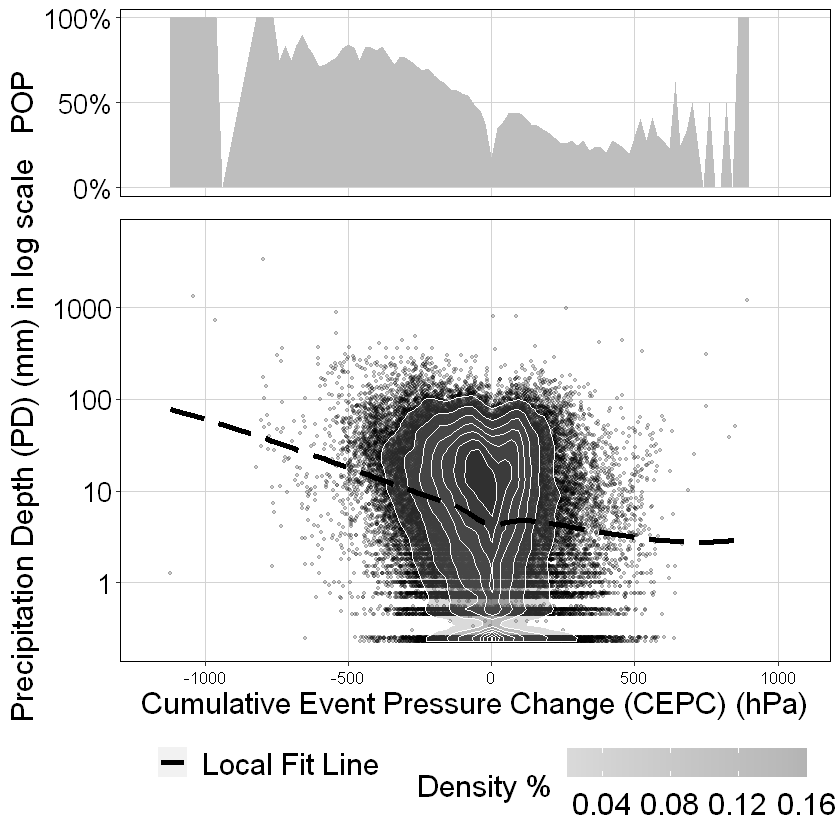

In [26]:
require(gridExtra)
Raw_dt_evt_all_loc_all %>% 
  mutate(Sum_Press_Delta=as.numeric(Sum_Press_Delta)) %>%
  mutate(Evt_Press_chng=round(Sum_Press_Delta/20)*20,
         RainEvt=St_Rain>0) %>% 
  group_by(Evt_Press_chng) %>% 
  summarise(RainProb=sum(RainEvt,na.rm=TRUE)/n(),
            samplesize=n()) %>% 
  ggplot(aes(x=Evt_Press_chng,y=RainProb))+
  geom_area(size=2,fill="grey")+
  scale_y_continuous(labels = scales::percent,breaks = c(0,0.5,1))+
  ylab('POP')+
  xlab('Event Pressure Change (hPa)')+
  xlim(-1182,1071)+
  theme_Result +
  theme(axis.title.x=element_blank(),
        axis.text.x=element_blank(),
        axis.ticks.x=element_blank())->P_area


Raw_dt_evt_all_loc_all %>% 
  mutate(Sum_Press_Delta=as.numeric(Sum_Press_Delta),
         Sum_Precip=as.numeric(Sum_Precip)) %>%
  filter(Sum_Precip>0) %>% 
  select(Sum_Press_Delta,Sum_Precip) %>% 
  ggplot(aes(x=Sum_Press_Delta))+
  geom_point(aes(y=Sum_Precip),alpha=0.2,size=0.7)+
  stat_density_2d(aes(y=Sum_Precip,fill=(..level..*100)),geom='polygon',color="white")+
  geom_smooth(aes(y=Sum_Precip,group = 1, color = "Local Fit Line"), method = "loess", size = 1.5, linetype = 5, se = FALSE)+
  scale_y_log10()+
  scale_color_manual("",values=c("black"))+
  #scale_alpha_continuous("Density %")+
  scale_fill_gradient("Density %",low=alpha("#828282", 0.3),high=alpha("#000000",0.3))+
  guides(fill = guide_colorbar(barwidth = 10))+
  ylab('Precipitation Depth (PD) (mm) in log scale')+
  xlab('Cumulative Event Pressure Change (CEPC) (hPa)')+
  xlim(-1182,1071)+
  theme_Result -> P_den


gA <- ggplotGrob(P_area)
gB <- ggplotGrob(P_den)
maxWidth = grid::unit.pmax(gA$widths[2:5], gB$widths[2:5])
gA$widths[2:5] <- as.list(maxWidth)
gB$widths[2:5] <- as.list(maxWidth)
grid.arrange(gA, gB, layout_matrix = rbind(c(1),c(2),c(2),c(2)))

g <- arrangeGrob(gA, gB, layout_matrix = rbind(c(1),c(2),c(2),c(2))) #generates g

## Fig.4 Monthly temperature vs PCE frequency

`geom_smooth()` using method = 'gam' and formula 'y ~ s(x, bs = "cs")'

Warning message:
"Removed 9 rows containing non-finite values (stat_smooth)."
Warning message:
"Removed 9 rows containing missing values (geom_point)."


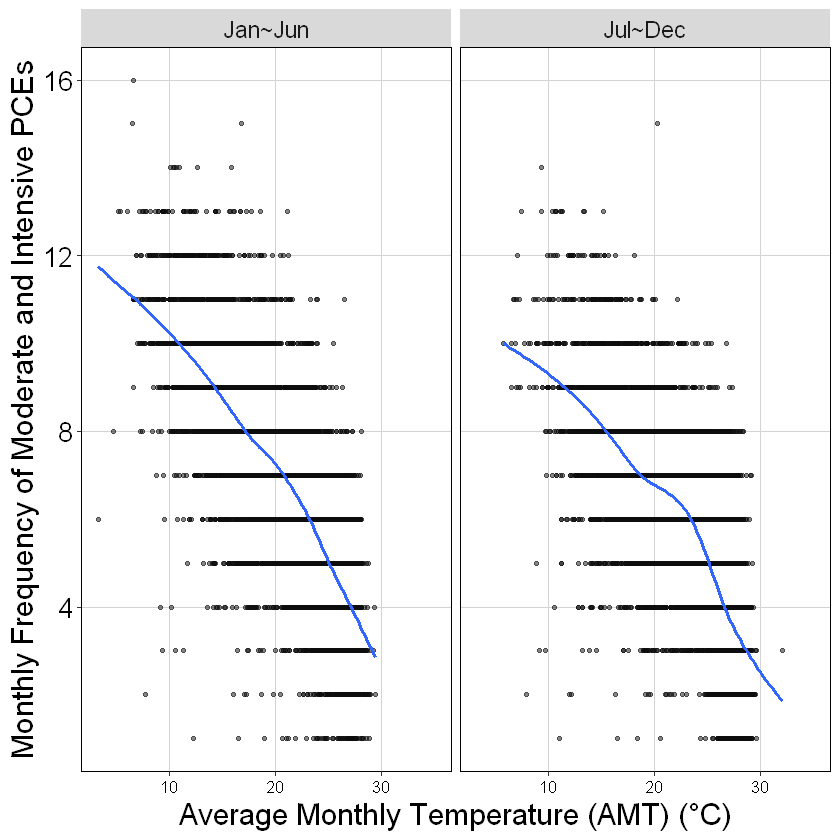

In [27]:
Raw_dt_evt_all_loc_all %>% 
  mutate(Sum_Press_Delta=as.numeric(Sum_Press_Delta),
         MonT=as.numeric(MonT)) %>% 
  mutate(PCE_mon=month(St)) %>% #pull(Sum_Press_Delta) %>% abs %>% summary
  filter(abs(Sum_Press_Delta)>90) %>% 
  group_by(PCE_mon,MonT) %>% 
  tally %>% 
  #filter(Loc=="PHL",data.table::between(PCE_mon,7,9)) %>% 
  mutate(HlfYr=ifelse(PCE_mon<7,"Jan~Jun","Jul~Dec")) %>% 
  ggplot(aes(x=MonT,y=n))+
  geom_point(alpha=0.5,size=1,color="grey5")+
  #geom_boxplot(aes(,y=n))+
  facet_grid(.~HlfYr)+
  stat_smooth(se=FALSE)+
  labs(y="Monthly Frequency of Moderate and Intensive PCEs",
       x="Average Monthly Temperature (AMT) (\u00B0C)")+
  theme_Result+
  theme(strip.text.x = element_text(size = 14))+
  xlim(NA, 35)

## Fig.5 Seasonal relationship between PD, AMT, and EPC in different percentiles

`summarise()` has grouped output by 'MonT', 'Sum_Press_Delta'. You can override using the `.groups` argument.

Warning message:
"Transformation introduced infinite values in continuous y-axis"
`geom_smooth()` using method = 'loess' and formula 'y ~ x'

Warning message:
"Removed 454 rows containing non-finite values (stat_smooth)."
`geom_smooth()` using method = 'loess' and formula 'y ~ x'

Warning message:
"Removed 454 rows containing non-finite values (stat_smooth)."
Warning message:
"Removed 454 rows containing missing values (geom_point)."


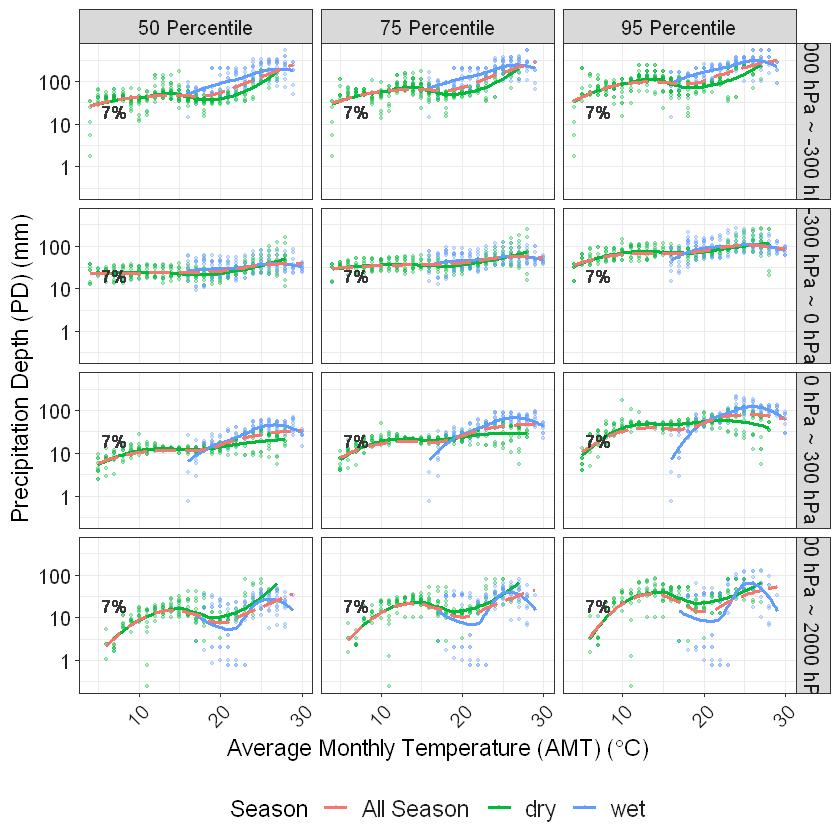

In [32]:
Raw_dt_evt_all_loc_all %>% 
  filter(Press_NA<1) %>% 
  # mutate(Season = as.character(cut(month(St),
  #                                  c(2, 5, 8, 11),
  #                                  c("Spring (MAM)", "Summer (JJA)", "Fall (SON), Winter (DJF) ")
  # ))) %>%
  mutate(mon = month(St)) %>% 
  mutate(Season = ifelse(between(mon,6,10), 'wet', 'dry')) %>% 
  # replace_na(list(Season = "Winter (DJF)")) %>%
  mutate(
    Sum_Press_Delta = as.numeric(Sum_Press_Delta) %/% 30 * 30,
    #EPC_int = as.numeric(EPC_int),
    MonT = as.numeric(MonT) %/% 1 * 1,
    Dur = as.numeric(Dur),
    Sum_Precip = as.numeric(Sum_Precip)
  ) %>%
  mutate(
    MonT1 = MonT - 1,
    MonT2 = MonT + 1,
    Sum_Press_Delta1 = Sum_Press_Delta - 30,
    Sum_Press_Delta2 = Sum_Press_Delta + 30
  ) %>%
  filter(Sum_Precip > 0) %>%
  select(
    MonT,
    MonT1,
    MonT2,
    Sum_Press_Delta,
    Sum_Press_Delta1,
    Sum_Press_Delta2,
    Season,
    Sum_Precip
  ) %>%
  gather(
    MonT_C,
    MonT,
    -Sum_Press_Delta,
    -Sum_Press_Delta1,
    -Sum_Press_Delta2,
    -Season,
    -Sum_Precip
  ) %>%
  gather(Sum_Press_Delta_C,
         Sum_Press_Delta,
         -MonT_C,
         -MonT,
         -Season,
         -Sum_Precip) %>%
  group_by(MonT, Sum_Press_Delta, Season) %>%
  mutate(
    `95%` = quantile(Sum_Precip, probs = 0.95),
    `75%` = quantile(Sum_Precip, probs = 0.75),
    `50%` = quantile(Sum_Precip, probs = 0.50)
  ) %>%
  summarise(
    `95 Percentile` = mean(ifelse(Sum_Precip > `95%`, Sum_Precip, NaN),na.rm = T),
    `75 Percentile` = mean(ifelse(Sum_Precip > `75%`, Sum_Precip, NaN),na.rm = T),
    `50 Percentile` = mean(ifelse(Sum_Precip > `50%`, Sum_Precip, NaN),na.rm = T)
  ) %>%
  filter(Sum_Press_Delta < 2000 & Sum_Press_Delta >-2000) %>% 
  gather(Qntile, Sum_Precip, -MonT, -Sum_Press_Delta, -Season) %>%
  mutate(Sum_Press_C = as.character(cut(
    Sum_Press_Delta,
    c(-2000, -300, 0, 300, 2000),
    c(
      "-2000 hPa ~ -300 hPa",
      "-300 hPa ~ 0 hPa",
      "0 hPa ~ 300 hPa",
      "300 hPa ~ 2000 hPa"
    )
  ))) -> Df4Plot


Df4Plot %>%
  {
    df = .
    df %>%
      mutate(Season = "All Season") -> df1
    
    ggplot(data = df, aes(x = MonT, y = Sum_Precip
                          , color = Season)) +
      geom_point(alpha = 0.3, size = 0.7) +
      stat_smooth(se = F, size = 1) +
      geom_smooth(
        data = df1,
        aes(x = MonT, y = Sum_Precip),
        se = F,
        linetype = "longdash"
      ) +
      facet_grid(Sum_Press_C ~ Qntile) +
      labs(x = expression(paste(
        "Average Monthly Temperature (AMT) (", degree, "C)"
      )),
      y = "Precipitation Depth (PD) (mm)") + 
      geom_abline(intercept = 0, slope = 0.07, linetype="dotted")+
      geom_text(aes(7,20),label = '7%', color = '#373638')+
      scale_y_log10()+
      #scale_color_discrete("")+
      # scale_color_manual(
      #   "",
      #   breaks = c(
      #     "All Season",
      #     "Fall (SON)",
      #     "Spring (MAM)",
      #     "Summer (JJA)",
      #     "Winter (DJF)"
      #   ),
      #   values = c("#000000", "#E69F00", "#56B4E9", "#009E73", "#D55E00")
    # ) +
    # ylim(0,150)+
    Plot_theme
  }

## Fig.6 Quantile ranges of absolute humidity (AH) in extreme Pressure Change Events (PCEs) responding to precipitation. 

### Data selection

In [47]:
Raw_dt_all_loc_all %>% 
  filter(Rain > 0 & lag(Rain) == 0 & lag(Rain,2)== 0  & lag(Rain,3)== 0 & lag(Rain,4)== 0 & lag(Rain,5)== 0 & lag(Rain,6)== 0 & 
           lag(Rain,7)== 0 & lag(Rain,8)== 0 & lag(Rain,9)== 0 &lag(Rain,10)== 0 & lag(Rain,11)== 0 & lag(Rain,12)== 0 & 
           lag(Rain,13)== 0 & lag(Rain,14)== 0 & lag(Rain,15)== 0 & lag(Rain,16)== 0 & lag(Rain,17)== 0 & lag(Rain,18)== 0 & 
           lag(Rain,19)== 0 & lag(Rain,20)== 0 & lag(Rain,21)== 0 & lag(Rain,22)== 0 & lag(Rain,23)== 0 & lag(Rain,24)== 0 & is.na(lag(Rain, 24)) == F & 

           lead(Rain,1)== 0 & lead(Rain,2)== 0 & lead(Rain,3)== 0 & lead(Rain,4)== 0 & lead(Rain,5)== 0 & lead(Rain,6)== 0 & 
           lead(Rain,7)== 0 & lead(Rain,8)== 0 & lead(Rain,9)== 0 & lead(Rain,10)== 0 & lead(Rain,11)== 0 & lead(Rain,12)== 0 & 
           lead(Rain,13)== 0 & lead(Rain,14)== 0 & lead(Rain,15)== 0 & lead(Rain,16)== 0 & lead(Rain,17)== 0 & lead(Rain,18)== 0 &
           lead(Rain,19)== 0 & lead(Rain,20)== 0 & lead(Rain,21)== 0 & lead(Rain,22)== 0 & lead(Rain,23)== 0 & lead(Rain,24)== 0 & 
           is.na(lead(Rain, 24)) == F) -> record


record %>% 
  mutate(lag_time = Time - hms("24:00:00"),
         lead_time = Time + hms("24:00:00")) -> AH_Rain



df_pl <- NULL

for (i in 1:dim(AH_Rain)[1]){
  lag <- AH_Rain[i,'lag_time']
  lead <- AH_Rain[i, 'lead_time']
  loca <- AH_Rain[i, 'Location']
  
  Raw_dt_all_loc_all %>%
    filter(data.table::between(Time, lag, lead), Location == as.character(loca)) %>% 
    mutate(RH.av = mean(RH))-> temp
    
  # temp[1:24,] %>% mutate(RH.av = mean(RH)) -> left
  # temp[26:49,] %>% mutate(RH.av = mean(RH)) -> right
  # 
  

    if (dim(temp)[1] != 49){
      next
    }
  
    temp[]
    temp_df <- data.frame(x = -24:24, y = temp['AH'], z = temp['Time'], A = temp['Location'], B = temp['Pressure_chng.av'], C = temp['RH.av'])
    df_pl <- rbind(df_pl, temp_df)

}

df_pl %>%
  mutate(Season = ifelse(between(month(Time),6,10), 'wet', 'dry')) -> df_pl



df_pl %>%
  filter(Pressure_chng.av < -300) %>%
  filter(Season == 'wet') %>% 
  mutate(RH.av = as.numeric(RH.av)) %>%
  mutate(Wet300_RH.av = mean(RH.av, na.rm = T)) %>%
  group_by(x) %>% 
  mutate(qunt5 = quantile(AH, 0.05, na.rm = T)) %>% 
  mutate(qunt25 = quantile(AH, 0.25, na.rm = T)) %>% 
  mutate(qunt48 = quantile(AH, 0.48, na.rm = T)) %>% 
  mutate(qunt52 = quantile(AH, 0.52, na.rm = T)) %>% 
  mutate(qunt75 = quantile(AH, 0.75, na.rm = T)) %>% 
  mutate(qunt95 = quantile(AH, 0.95, na.rm = T)) %>% 
  mutate(q50_wet300 = quantile(AH, 0.5, na.rm = T)) %>% 
  mutate(colr = ifelse(between(AH, qunt25, qunt75), 'Q25~75',
                       ifelse(between(AH, qunt5, qunt95), 'Q5~95', '<Q5 || >Q95')))-> df_pl_300_wet





df_pl %>%
  filter(Pressure_chng.av < -300) %>%
  filter(Season =='dry') %>% 
  mutate(dry300_RH.av = mean(RH.av, na.rm = T)) %>% 
  group_by(x) %>% 
  mutate(qunt5 = quantile(AH, 0.05, na.rm = T)) %>% 
  mutate(qunt25 = quantile(AH, 0.25, na.rm = T)) %>% 
  mutate(qunt48 = quantile(AH, 0.48, na.rm = T)) %>% 
  mutate(qunt52 = quantile(AH, 0.52, na.rm = T)) %>% 
  mutate(qunt75 = quantile(AH, 0.75, na.rm = T)) %>% 
  mutate(qunt95 = quantile(AH, 0.95, na.rm = T)) %>% 
  mutate(q50_dry300 = quantile(AH, 0.5, na.rm = T)) %>% 
  mutate(colr = ifelse(between(AH, qunt25, qunt75), 'Q25~75',
                       ifelse(between(AH, qunt5, qunt95), 'Q5~95', '<Q5 || >Q95')))-> df_pl_300_dry

#
#
df_pl %>%
  filter(Pressure_chng.av > 300) %>%
  filter(Season == 'wet') %>% 
  mutate(Wet150_RH.av = mean(RH.av, na.rm = T)) %>% 
  group_by(x) %>%  
  mutate(qunt5 = quantile(AH, 0.05, na.rm = T)) %>% 
  mutate(qunt25 = quantile(AH, 0.25, na.rm = T)) %>% 
  mutate(qunt48 = quantile(AH, 0.48, na.rm = T)) %>% 
  mutate(qunt52 = quantile(AH, 0.52, na.rm = T)) %>% 
  mutate(qunt75 = quantile(AH, 0.75, na.rm = T)) %>% 
  mutate(qunt95 = quantile(AH, 0.95, na.rm = T)) %>% 
  mutate(q50_wet150 = quantile(AH, 0.5, na.rm = T)) %>% 
  mutate(colr = ifelse(between(AH, qunt25, qunt75), 'Q25~75',
                       ifelse(between(AH, qunt5, qunt95), 'Q5~95', '<Q5 || >Q95'))) -> df_pl_150_wet


df_pl %>%
  filter(Pressure_chng.av > 300) %>%
  filter(Season == 'dry') %>% 
  mutate(dry150_RH.av = mean(RH.av, na.rm = T)) %>% 
  group_by(x) %>%  
  mutate(qunt5 = quantile(AH, 0.05, na.rm = T)) %>% 
  mutate(qunt25 = quantile(AH, 0.25, na.rm = T)) %>% 
  mutate(qunt48 = quantile(AH, 0.48, na.rm = T)) %>% 
  mutate(qunt52 = quantile(AH, 0.52, na.rm = T)) %>% 
  mutate(qunt75 = quantile(AH, 0.75, na.rm = T)) %>% 
  mutate(qunt95 = quantile(AH, 0.95, na.rm = T)) %>% 
  mutate(q50_dry150 = quantile(AH, 0.5, na.rm = T)) %>% 
  mutate(colr = ifelse(between(AH, qunt25, qunt75), 'Q25~75',
                       ifelse(between(AH, qunt5, qunt95), 'Q5~95', '<Q5 || >Q95')))-> df_pl_150_dry



### Plot Fig.6

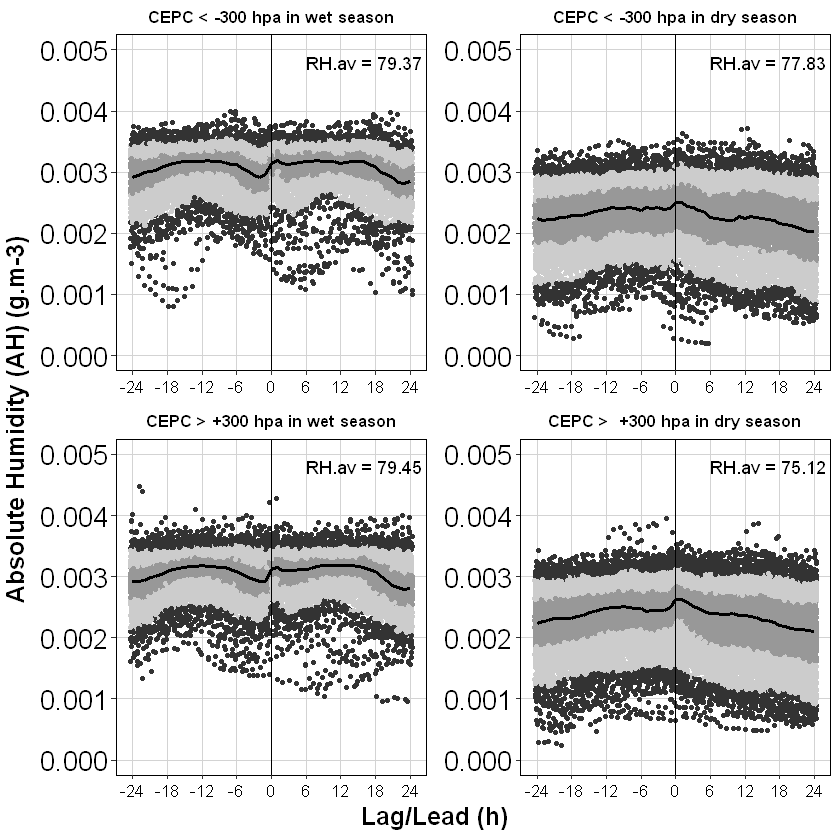

In [52]:
# -300 hpa wet
ggplot(df_pl_300_wet, aes(x= x, y =AH, colour = as.factor(colr)), show.legend = FALSE)+
  geom_jitter(size = 1, na.rm = T)+
  geom_line(data = df_pl_300_wet, aes(x = x, y = q50_wet300), colour = 'black', size = 1)+

  scale_color_grey()+
  geom_vline(aes(xintercept =0), )+

  scale_x_continuous(breaks = c(-24,-18,-12,-6,0,6,12,18,24))+
  guides(col = 'none')+
  theme_Result+
  theme(axis.title.x=element_blank(),
        axis.title.y=element_blank())+
  annotate("text", x = 18, y = 0.0048, label = "RH.av = 79.37 %")+
  ylim(0,0.005)+
  ggtitle('CEPC < -300 hpa in wet season')+
  theme(plot.title = element_text(size = 10, hjust = 0.5, face = "bold"))-> wet300
#
#
#
#
# -300 hpa dry
ggplot(df_pl_300_dry, aes(x= x, y =AH, colour = as.factor(colr)), show.legend = FALSE)+
  geom_jitter(size = 1, na.rm = T)+
  geom_line(data = df_pl_300_dry, aes(x = x, y = q50_dry300), colour = 'black', size = 1)+

  scale_color_grey()+
  geom_vline(aes(xintercept =0), )+
  scale_x_continuous(breaks = c(-24,-18,-12,-6,0,6,12,18,24))+
  guides(col = 'none')+
  theme_Result+
  theme(axis.title.x=element_blank(),
        axis.title.y=element_blank())+
  annotate("text", x = 18, y = 0.0048, label = "RH.av = 77.83 %")+
  ylim(0,0.005)+
  ggtitle('CEPC < -300 hpa in dry season')+
  theme(plot.title = element_text(size = 10, hjust = 0.5, face = "bold"))-> dry300



# 150 hpa wet
ggplot(df_pl_150_wet, aes(x= x, y =AH, colour = as.factor(colr)), show.legend = FALSE)+
  geom_jitter(size = 1, na.rm = T)+
  geom_line(data = df_pl_150_wet, aes(x = x, y = q50_wet150), colour = 'black', size = 1)+

  scale_color_grey()+
  geom_vline(aes(xintercept =0), )+
  scale_x_continuous(breaks = c(-24,-18,-12,-6,0,6,12,18,24))+
  guides(col = 'none')+
  theme_Result+
  theme(axis.title.x=element_blank(),
        axis.title.y=element_blank())+
  annotate("text", x = 18, y = 0.0048, label = "RH.av = 79.45 %")+
  ylim(0,0.005)+
  ggtitle('CEPC > +300 hpa in wet season')+
  theme(plot.title = element_text(size = 10, hjust = 0.5, face = "bold"))-> wet150




# 150 hpa dry
ggplot(df_pl_150_dry, aes(x= x, y =AH, colour = as.factor(colr)), show.legend = FALSE)+
  geom_jitter(size = 1, na.rm = T)+
  geom_line(data = df_pl_150_dry, aes(x = x, y = q50_dry150), colour = 'black', size = 1)+

  scale_color_grey()+
  geom_vline(aes(xintercept =0), )+
  scale_x_continuous(breaks = c(-24,-18,-12,-6,0,6,12,18,24))+
  guides(col = 'none')+
  theme_Result+
  theme(axis.title.x=element_blank(),
        axis.title.y=element_blank())+
  annotate("text", x = 18, y = 0.0048, label = "RH.av = 75.12 %")+
  ylim(0,0.005)+
  ggtitle('CEPC >  +300 hpa in dry season')+
  theme(plot.title = element_text(size = 10, hjust = 0.5, face = "bold"))-> dry150


library(cowplot)
library(gridExtra)
library(ggplot2)
library(ggpubr)
gA <- ggplotGrob(wet300)
gB <- ggplotGrob(dry300)
gC <- ggplotGrob(wet150)
gD <- ggplotGrob(dry150)
maxWidth = grid::unit.pmax(gA$widths[2:5], gB$widths[2:5], gC$widths[2:5], gD$widths[2:5])

gA$widths[2:5] <- as.list(maxWidth)
gB$widths[2:5] <- as.list(maxWidth)
gC$widths[2:5] <- as.list(maxWidth)
gD$widths[2:5] <- as.list(maxWidth)


grid.arrange(gA, gB, gC, gD, ncol = 2, nrow = 2,left = ggpubr::text_grob("Absolute Humidity (AH) (g.m-3)", 
                                                                         rot = 90, 
                                                                         vjust = 0.4,
                                                                         face = "bold",
                                                                         size = 15
                                                                         ),
             bottom = ggpubr::text_grob("Lag/Lead (h)", 
                                        rot = 0, 
                                        vjust = 0,
                                        face = "bold",
                                        size = 15
                                        )) 


